<a href="https://colab.research.google.com/github/create-alt/CNN_for_Cifar10/blob/main/CNN_for_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNNによるCifar-10分類**

環境：<br>
Google Colaboratory<br>
T4 GPU<br>
必要ライブラリ等はコード内で記述

# GPU確認とGoogleDrive接続

モデルの学習時にGPUが必要となるので接続を確認しておく。

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17494351412806949153
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15213497942736662699
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

学習した結果の重みをGoogleDriveに保存するため接続しておく。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd {"/content/drive/MyDrive/重みを格納するフォルダ"}

/content/drive/MyDrive/AI実践_cifar10


# ライブラリのimportと定数・関数定義

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
from sklearn.model_selection import StratifiedKFold
import os
import cv2
import gc

import keras
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, AveragePooling2D, AveragePooling3D

label_dict = {0:"飛行機", 1:"自動車", 2:"鳥", 3:"猫", 4:"鹿", 5:"犬", 6:"カエル", 7:"馬", 8:"船", 9:"トラック"} #label定義

#定数定義（class作成時にまとめられる）
NUM_CLASSES = 10
SEED=0

In [ ]:
#データを読み込む
def load():
  (X_train,y_train),(X_test,y_test) = cifar10.load_data()
  print("default X_train's shape is",X_train.shape)
  print("default y_train's shape is",y_train.shape,"\n")

  # 入力データ[0, 1]の範囲に正規化
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')
  # 255で割ったものを新たに変数とする->画素の最大が255なので、255で割ると[0, 1]になる
  X_train /= 255
  X_test /= 255

  #以下データ拡張

  #seed値固定
  tf.random.set_seed(SEED)

  params = {"zoom_range" : 0.3,
          "horizontal_flip" : True,
          "rotation_range" : 30,
          "height_shift_range": 0.1,
          "width_shift_range": 0.1,
          "channel_shift_range": 0.3}

  #データ拡張用オブジェクトの定義
  data_generator = keras.preprocessing.image.ImageDataGenerator(**params)

  # 同じ画像を複製する
  train_aug = X_train.copy()
  train_aug = np.concatenate([train_aug,train_aug])

  y_aug = np.concatenate([y_train,y_train])

  #データ拡張
  generator = data_generator.flow(train_aug, y_aug, batch_size=100000)

  # 変換後のデータを取得
  batch_x = generator.next()

  X_train = np.concatenate([X_train,batch_x[0]])
  y_train = np.concatenate([y_train,batch_x[1]])

  print(X_train.shape)

  return (X_train,y_train),(X_test,y_test)

#plot用関数(教材から引用)
def plot_history_of_model(model):
    # 学習をグラフ化（正解率）
    print(model.history.history)
    acc = model.history.history['accuracy']
    val_acc = model.history.history['val_accuracy']

    # Accuracy Plot
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylim(0.0,1.0)
    plt.title('Accuracy')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

    # Loss Plot
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    plt.plot(loss ,label = 'training loss')
    plt.plot(val_loss, label= 'validation loss')
    #plt.ylim(0,3)
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

#checkpointの設定
def create_checkpoint(path):
  #path(TensorFlow公式サイトより引用 https://www.tensorflow.org/tutorials/keras/save_and_load?hl=ja)

  #重みの格納場所(公式サイトでは.ckptを使用していたが安全性の面から.safetensorsを使用)
  checkpoint_path = "Weight_of_model/" + path + ".safetensors"
  checkpoint_dir = os.path.dirname(checkpoint_path)

  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)

  return checkpoint_path,cp_callback

#3次元データ用のニューラルネットワーク
def create_3Dmodel():
  #seed値固定
  tf.random.set_seed(SEED)
  # マスクを適応したカラー画像に関するモデル
  model = Sequential()

  model.add(Conv3D(64, kernel_size=(3, 3, 1),
                                padding="SAME",
                                activation='relu'))
  model.add(Dropout(0.3))
  model.add(Conv3D(64, (3, 3, 1), padding="SAME",activation='relu'))
  model.add(MaxPooling3D(pool_size=(3, 3, 1))) # max pooling layer
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Conv3D(128, (3, 3, 1), padding="SAME" ,activation='relu'))
  model.add(Dropout(0.3))
  model.add(Conv3D(128, (3, 3, 1), padding="SAME" ,activation='relu'))
  model.add(MaxPooling3D(pool_size=(3, 3, 1))) # max pooling layer
  model.add(Dropout(0.3))

  model.add(Flatten())

  model.add(Dense(256, activation='relu')) # 全結合層
  model.add(Dense(NUM_CLASSES, activation='softmax')) #classごとに確率を出力

  # 損失関数,最適化関数,評価指標を指定してモデルをコンパイル->学習できる形にする
  model.compile(loss=keras.losses.categorical_crossentropy,
          #optimizer=keras.optimizers.Adadelta(),
          optimizer=tf.keras.optimizers.Adam(),
          metrics=['accuracy'])

  return model

#2次元データ用のニューラルネットワーク
def create_2Dmodel(input_size):
  #seed値固定
  tf.random.set_seed(SEED)
  # グレースケール化した画像に対するモデル
  model = Sequential()
  #addで層を追加する,↓だとconv2dを追加
  model.add(Conv2D(64, kernel_size=(3, 3),padding="SAME",
                        activation='relu',
                        input_shape=input_size)) # 3×3のカーネルサイズの2D Convolution layer
  model.add(Conv2D(64, (3, 3),padding="SAME", activation='relu'))
  model.add(Dropout(0.3))

  model.add(Conv2D(64, (3, 3),padding="SAME", activation='relu'))
  model.add(Dropout(0.3))
  model.add(Conv2D(64, (3, 3),padding="SAME", activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (3,3),padding="SAME",activation='relu'))
  model.add(Conv2D(128, (3,3),padding="SAME",activation='relu'))
  model.add(Dropout(0.3))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  model.add(Flatten())
  model.add(Dense(256, activation='relu')) # 全結合層
  model.add(Dense(NUM_CLASSES, activation='softmax'))

  # モデルの学習
  # 損失関数,最適化関数,評価指標を指定してモデルをコンパイル->学習できる形にする
  model.compile(loss=keras.losses.categorical_crossentropy,
                            #optimizer=keras.optimizers.Adadelta(),
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])

  return model

# 分類モデルの構築と学習

In [ ]:
(X_train,y_train),(X_test,y_test) = load()
#画像サイズ指定
img_rows, img_cols = X_train.shape[1], X_train.shape[2]

170498071/170498071 [==============================] - 2s 0us/step
default X_train's shape is (50000, 32, 32, 3)
default y_train's shape is (50000, 1) 

(150000, 32, 32, 3)


次のコードでは特に分類精度の低かった猫データについて追加拡張を行っている。

In [ ]:
X_cat = X_train[np.where(y_train == 3)[0]]

tf.random.set_seed(SEED)

params = {"zoom_range" : 0.3,
        "horizontal_flip" : True,
        "rotation_range" : 30,
        "height_shift_range": 0.1,
        "width_shift_range": 0.1,
        "channel_shift_range": 0.3}

#データ拡張用オブジェクトの定義
data_generator = keras.preprocessing.image.ImageDataGenerator(**params)

# 同じ画像を複製する
train_aug = X_cat.copy()

y_aug = y_train[np.where(y_train == 3)[0]]

#データ拡張
generator = data_generator.flow(train_aug, y_aug, batch_size=15000)

# 変換後のデータを取得
batch_x = generator.next()

X_train = np.concatenate([X_train,batch_x[0]])
y_train = np.concatenate([y_train,batch_x[1]])

print(X_train.shape)
print(y_train.shape)

(165000, 32, 32, 3)
(165000, 1)


In [ ]:
n_split=3 #いくつに分割するか（何度学習するか）今回は1度のみ学習します
kf = StratifiedKFold(n_split,shuffle=True,random_state=0)
split_index=[[] for i in range(n_split)] #分割後のindexを格納するためのlist

#train_indexは学習用データのindex,valid_indexはtest用データのindex(X,y共用)
for fold,(train_index, valid_index) in enumerate(kf.split(X_train,y_train)):
    split_index[fold] = [train_index,valid_index]

print(split_index)

[[array([     2,      3,      7, ..., 164995, 164997, 164998]), array([     0,      1,      4, ..., 164993, 164996, 164999])], [array([     0,      1,      2, ..., 164996, 164998, 164999]), array([     3,     10,     15, ..., 164994, 164995, 164997])], [array([     0,      1,      3, ..., 164996, 164997, 164999]), array([     2,      7,      8, ..., 164991, 164992, 164998])]]


In [ ]:
#データをkerasが読み取れる形式に変換する(one-hotベクトル)
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)
print("y_train's shape after change to one-hot vec is",y_train.shape)

y_train's shape after change to one-hot vec is (165000, 10)


In [ ]:
X_train = np.expand_dims(X_train, axis=-1)  # 最後の次元にチャンネル数を追加
X_test = np.expand_dims(X_test, axis=-1)  # 最後の次元にチャンネル数を追加

In [ ]:
checkpoint_path, cp_callback = create_checkpoint("重みを保存するファイルのパスをここに記載")

Epoch 1/32
860/860 [==============================] - ETA: 0s - loss: 1.7493 - accuracy: 0.3774
Epoch 1: saving model to Weight_of_model/Original/cat_data_inc.safetensors
860/860 [==============================] - 106s 111ms/step - loss: 1.7493 - accuracy: 0.3774 - val_loss: 1.5193 - val_accuracy: 0.4692
Epoch 2/32
859/860 [============================>.] - ETA: 0s - loss: 1.4048 - accuracy: 0.5078
Epoch 2: saving model to Weight_of_model/Original/cat_data_inc.safetensors
860/860 [==============================] - 82s 95ms/step - loss: 1.4048 - accuracy: 0.5079 - val_loss: 1.3861 - val_accuracy: 0.5180
Epoch 3/32
859/860 [============================>.] - ETA: 0s - loss: 1.2287 - accuracy: 0.5724
Epoch 3: saving model to Weight_of_model/Original/cat_data_inc.safetensors
860/860 [==============================] - 81s 95ms/step - loss: 1.2287 - accuracy: 0.5724 - val_loss: 1.3048 - val_accuracy: 0.5477
Epoch 4/32
859/860 [============================>.] - ETA: 0s - loss: 1.1275 - accurac

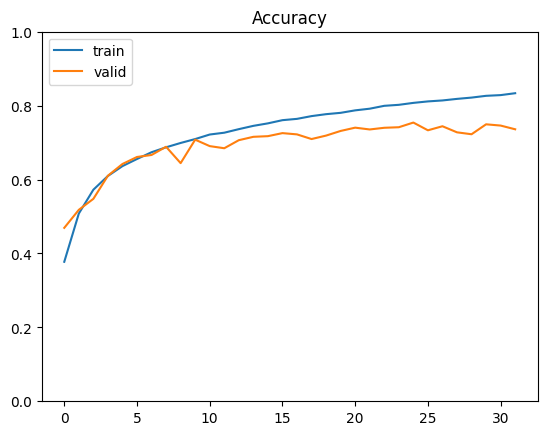

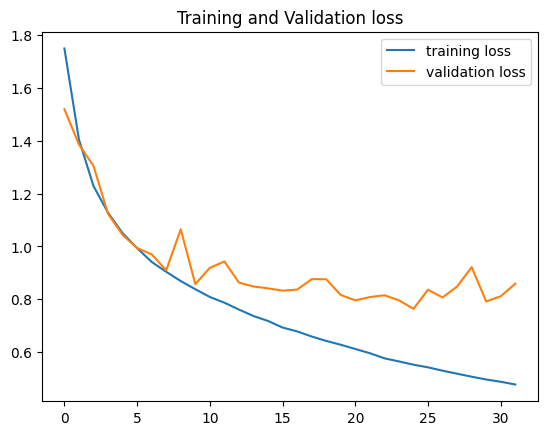

In [ ]:
NUMBER_OF_EPOCH = 32
BATCH_SIZE = 128

model_color = create_3Dmodel()

# モデルの学習
model_color.fit(X_train[split_index[0][0]], y_train[split_index[0][0]],
                batch_size=BATCH_SIZE,
                epochs=NUMBER_OF_EPOCH,
                verbose=1,
                validation_data=(X_train[split_index[0][1]], y_train[split_index[0][1]]),
                callbacks=[cp_callback])

plot_history_of_model(model_color)

#データ10万
#loss: 0.1955 - accuracy: 0.9300 - val_loss: 0.9620 - val_accuracy: 0.7557

In [ ]:
"""
#保存した重みの読み込み
model_color = create_3Dmodel()

model_color.load_weights(checkpoint_path)
"""

In [ ]:
pred_color = model_color.predict(X_test)
count = 0
for i in range(len(X_test)):
    if np.argmax(pred_color[i]) == np.argmax(y_test[i]):
        count +=1

print("accuracy :",count/len(X_test))

#accuracy : 0.8055

313/313 [==============================] - 8s 7ms/step
accuracy : 0.8035


In [ ]:
count = 0

negative_list = np.zeros(10)
pred_list = np.zeros(10)

true = np.zeros(10)
pred = np.zeros(10)

my_matrix = np.zeros((10,10))

for i in range(len(pred_color)):
    if np.argmax(pred_color[i]) == np.argmax(y_test[i]):
        count +=1
    else:
      negative_list[np.argmax(y_test[i])] += 1
      pred_list[np.argmax(pred_color[i])] += 1

    true[np.argmax(y_test[i])] += 1
    pred[np.argmax(pred_color[i])] += 1

    my_matrix[np.argmax(y_test[i])][np.argmax(pred_color[i])] += 1

print("accuracy :",count/len(pred_color))
print(label_dict)
print(negative_list)
print(pred_list,"\n")

print(true)
print(pred,"\n")

print(my_matrix)

accuracy : 0.8035
{0: '飛行機', 1: '自動車', 2: '鳥', 3: '猫', 4: '鹿', 5: '犬', 6: 'カエル', 7: '馬', 8: '船', 9: 'トラック'}
[159.  44. 315. 350. 267. 239. 114. 196. 122. 159.]
[173. 199. 190. 339. 163. 322. 233. 116. 124. 106.] 

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
[1014. 1155.  875.  989.  896. 1083. 1119.  920. 1002.  947.] 

[[841.  17.  25.  17.   7.   6.   6.   6.  46.  29.]
 [  2. 956.   2.   3.   3.   1.   3.   0.  11.  19.]
 [ 46.   7. 685.  47.  59.  59.  60.  23.   8.   6.]
 [ 29.  19.  38. 650.  25. 126.  71.  20.  10.  12.]
 [ 15.   3.  61.  46. 733.  46.  53.  33.   9.   1.]
 [ 10.   2.  27. 119.  20. 761.  24.  20.   7.  10.]
 [  6.   8.  15.  33.   7.  22. 886.   5.  14.   4.]
 [  9.   4.  13.  49.  37.  58.  12. 804.   2.  12.]
 [ 43.  36.   8.  12.   3.   2.   2.   3. 878.  13.]
 [ 13. 103.   1.  13.   2.   2.   2.   6.  17. 841.]]


In [ ]:
del X_train,X_test
gc.collect()

994

# 元データにマスク処理を施したデータに対する分類モデル

In [ ]:
(X_train,y_train),(X_test,y_test) = load()

default X_train's shape is (50000, 32, 32, 3)
default y_train's shape is (50000, 1) 

(150000, 32, 32, 3)


In [ ]:
X_cat = X_train[np.where(y_train == 3)[0]]

tf.random.set_seed(SEED)

params = {"zoom_range" : 0.3,
        "horizontal_flip" : True,
        "rotation_range" : 30,
        "height_shift_range": 0.1,
        "width_shift_range": 0.1,
        "channel_shift_range": 0.3}

#データ拡張用オブジェクトの定義
data_generator = keras.preprocessing.image.ImageDataGenerator(**params)

# 同じ画像を複製する
train_aug = X_cat.copy()

y_aug = y_train[np.where(y_train == 3)[0]]

#データ拡張
generator = data_generator.flow(train_aug, y_aug, batch_size=15000)

# 変換後のデータを取得
batch_x = generator.next()

X_train = np.concatenate([X_train,batch_x[0]])
y_train = np.concatenate([y_train,batch_x[1]])

print(X_train.shape)
print(y_train.shape)

(165000, 32, 32, 3)
(165000, 1)


次のコードでは画像へマスク処理を施している。

In [ ]:
row, col = np.ogrid[:img_rows, :img_cols]

cnt_row, cnt_col = img_rows / 2, img_cols / 2 # Center of the disk
outer_disk_mask = ((row - cnt_row)**2 + (col - cnt_col)**2 > (img_cols / 2)**2)

print(outer_disk_mask.shape)

X_train_masked = X_train.copy()
X_test_masked = X_test.copy()
for i in range(X_train.shape[0]):
    X_train_masked[i][outer_disk_mask] = 0
for i in range(X_test.shape[0]):
    X_test_masked[i][outer_disk_mask] = 0

#メモリ開放
del X_train,row,col,cnt_row,cnt_col
gc.collect()

(32, 32)


0

In [ ]:
#データをkerasが読み取れる形式に変換する(one-hotベクトル)
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)
print("y_train's shape after change to one-hot vec is",y_train.shape)

y_train's shape after change to one-hot vec is (165000, 10)


In [ ]:
X_train_masked = np.expand_dims(X_train_masked, axis=-1)  # 最後の次元にチャンネルを追加
X_test_masked = np.expand_dims(X_test, axis=-1)

In [ ]:
#checkpointの設定
checkpoint_path,cp_callback = create_checkpoint("重みを保存するファイルのパスをここに記載")

In [ ]:
#学習時には実行する
NUMBER_OF_EPOCH = 32
BATCH_SIZE = 128

model_color_masked = create_3Dmodel()

# モデルの学習
model_color_masked.fit(X_train_masked[split_index[0][0]], y_train[split_index[0][0]],
                      batch_size=BATCH_SIZE,
                      epochs=NUMBER_OF_EPOCH,
                      verbose=1,
                      validation_data=(X_train_masked[split_index[0][1]], y_train[split_index[0][1]]),
                      callbacks=[cp_callback])

#上記の5万データ + 64ephoc
#loss: 0.1717 - accuracy: 0.9413 - val_loss: 1.1171 - val_accuracy: 0.7557

#epoch32 データ拡張(データ合計15万)
#loss: 0.5442 - accuracy: 0.8089 - val_loss: 0.8114 - val_accuracy: 0.7362

Epoch 1/32
860/860 [==============================] - ETA: 0s - loss: 1.8582 - accuracy: 0.3376
Epoch 1: saving model to Weight_of_model/Masked/cat_data_inc.safetensors
860/860 [==============================] - 99s 108ms/step - loss: 1.8582 - accuracy: 0.3376 - val_loss: 1.6710 - val_accuracy: 0.4087
Epoch 2/32
859/860 [============================>.] - ETA: 0s - loss: 1.5702 - accuracy: 0.4435
Epoch 2: saving model to Weight_of_model/Masked/cat_data_inc.safetensors
860/860 [==============================] - 80s 93ms/step - loss: 1.5701 - accuracy: 0.4435 - val_loss: 1.4709 - val_accuracy: 0.4851
Epoch 3/32
859/860 [============================>.] - ETA: 0s - loss: 1.3876 - accuracy: 0.5124
Epoch 3: saving model to Weight_of_model/Masked/cat_data_inc.safetensors
860/860 [==============================] - 79s 92ms/step - loss: 1.3876 - accuracy: 0.5124 - val_loss: 1.3358 - val_accuracy: 0.5348
Epoch 4/32
859/860 [============================>.] - ETA: 0s - loss: 1.2552 - accuracy: 0.56

{'loss': [1.858224630355835, 1.5700809955596924, 1.387559413909912, 1.2552542686462402, 1.1676548719406128, 1.1023659706115723, 1.0553914308547974, 1.0105184316635132, 0.9733289480209351, 0.9425948262214661, 0.9130635857582092, 0.8911875486373901, 0.8657838106155396, 0.841191828250885, 0.825988233089447, 0.8032456040382385, 0.7850242257118225, 0.7661841511726379, 0.7526094317436218, 0.7298485040664673, 0.7197204828262329, 0.7111498713493347, 0.6921513676643372, 0.6846725344657898, 0.668104350566864, 0.6568887829780579, 0.6404602527618408, 0.6312060356140137, 0.6242024302482605, 0.6095792651176453, 0.6015132069587708, 0.591855525970459], 'accuracy': [0.33764544129371643, 0.44351819157600403, 0.5124363899230957, 0.5637545585632324, 0.5950000286102295, 0.6162545680999756, 0.6355000138282776, 0.6495181918144226, 0.6614000201225281, 0.6720545291900635, 0.684109091758728, 0.6905999779701233, 0.6993181705474854, 0.7068363428115845, 0.7127909064292908, 0.7207363843917847, 0.7264090776443481, 0

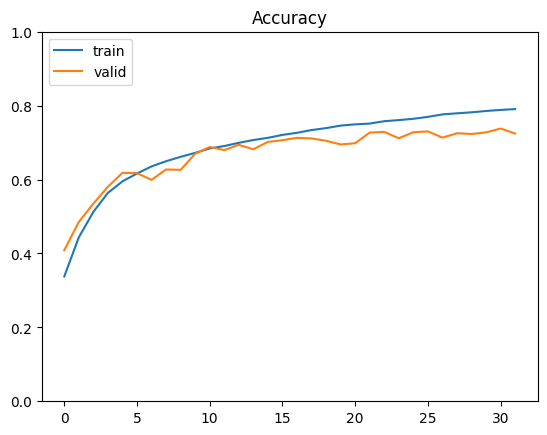

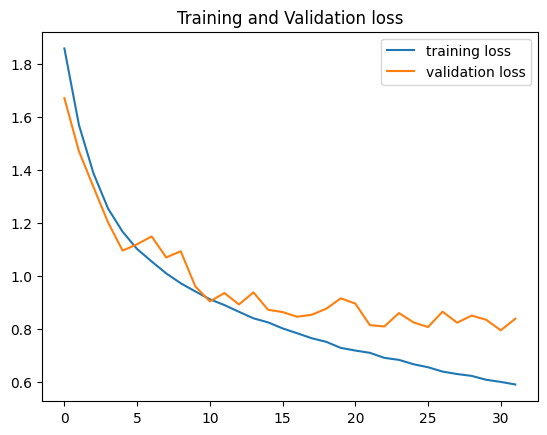

In [ ]:
plot_history_of_model(model_color_masked)

In [ ]:
"""
#保存した重みを読み込み、精度を出力
model_color_masked = create_3Dmodel()

model_color_masked.load_weights(checkpoint_path)

loss, acc = model_color_masked.evaluate(X_test_masked, y_test, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))
"""

313/313 - 8s - loss: 0.6461 - accuracy: 0.8071 - 8s/epoch - 27ms/step
Untrained model, accuracy: 80.71%


In [ ]:
del X_train_masked

gc.collect()

5309

In [ ]:
pred_color_masked = model_color_masked.predict(X_test_masked)

count = 0
for i in range(len(X_test_masked)):
    if np.argmax(pred_color_masked[i]) == np.argmax(y_test[i]):
        count +=1

print("accuracy :",count/len(X_test_masked))

313/313 [==============================] - 2s 6ms/step
accuracy : 0.7945


In [ ]:
del X_test_masked

gc.collect()

645

# グレースケール化した画像にマスクを適応させた画像についての分類モデル

In [ ]:
(X_train,y_train),(X_test,y_test) = load()

default X_train's shape is (50000, 32, 32, 3)
default y_train's shape is (50000, 1) 

(150000, 32, 32, 3)


In [ ]:
X_cat = X_train[np.where(y_train == 3)[0]]

tf.random.set_seed(SEED)

params = {"zoom_range" : 0.3,
        "horizontal_flip" : True,
        "rotation_range" : 30,
        "height_shift_range": 0.1,
        "width_shift_range": 0.1,
        "channel_shift_range": 0.3}

#データ拡張用オブジェクトの定義
data_generator = keras.preprocessing.image.ImageDataGenerator(**params)

# 同じ画像を複製する
train_aug = X_cat.copy()

y_aug = y_train[np.where(y_train == 3)[0]]

#データ拡張
generator = data_generator.flow(train_aug, y_aug, batch_size=15000)

# 変換後のデータを取得
batch_x = generator.next()

X_train = np.concatenate([X_train,batch_x[0]])
y_train = np.concatenate([y_train,batch_x[1]])

print(X_train.shape)
print(y_train.shape)

(165000, 32, 32, 3)
(165000, 1)


前回のモデル作成時に行ったマスク処理を施す。

In [ ]:
X_train_masked = X_train.copy()
X_test_masked = X_test.copy()
for i in range(X_train.shape[0]):
    X_train_masked[i][outer_disk_mask] = 0
for i in range(X_test.shape[0]):
    X_test_masked[i][outer_disk_mask] = 0

In [ ]:
del X_train,X_test,outer_disk_mask
gc.collect()

0

グレースケール化を施す。

In [ ]:
X_train_masked_gray = np.empty((X_train_masked.shape[0],32,32))

for i in range(X_train_masked.shape[0]):
    im_gray = cv2.cvtColor(X_train_masked[i], cv2.COLOR_BGR2GRAY)
    X_train_masked_gray[i] = im_gray

print("X_train_masked_gray's shape is",X_train_masked_gray.shape)


X_test_masked_gray = np.empty((X_test_masked.shape[0],X_test_masked.shape[1],X_test_masked.shape[2]))

for i in range(X_test_masked.shape[0]):
    im_gray = cv2.cvtColor(X_test_masked[i], cv2.COLOR_BGR2GRAY)
    X_test_masked_gray[i] = im_gray

print("X_test_masked_gray's shape is",X_test_masked_gray.shape)

X_train_masked_gray's shape is (165000, 32, 32)
X_test_masked_gray's shape is (10000, 32, 32)


In [ ]:
del X_train_masked,X_test_masked
gc.collect()

0

In [ ]:
#データをkerasが読み取れる形式に変換する(one-hotベクトル)
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)
print("y_train's shape after change to one-hot vec is",y_train.shape)

y_train's shape after change to one-hot vec is (165000, 10)


In [ ]:
#checkpointの設定
checkpoint_path,cp_callback = create_checkpoint("重みを保存するファイルのパスをここに記載")

'#model作成\ninput_size  = (img_rows,img_cols,1)\nmodel_masked_gray = create_2Dmodel(input_size)\n#重みのロード\nmodel_masked_gray.load_weights(checkpoint_path)\n\nloss, acc = model_masked_gray.evaluate(X_test_masked_gray, y_test, verbose=2)\nprint("Untrained model, accuracy: {:5.2f}%".format(100 * acc))'

In [ ]:
#https://qiita.com/yy1003/items/c590d1a26918e4abe512やhttps://deepage.net/deep_learning/2016/10/26/batch_normalization.html参照

NUMBER_OF_EPOCH = 32
BATCH_SIZE = 128

input_size  = (img_rows,img_cols,1)

model_masked_gray = create_2Dmodel(input_size)

model_masked_gray.fit(X_train_masked_gray[split_index[0][0]], y_train[split_index[0][0]],
                      batch_size=BATCH_SIZE,
                      epochs=NUMBER_OF_EPOCH,
                      verbose=1,
                      validation_data=(X_train_masked_gray[split_index[0][1]], y_train[split_index[0][1]]),
                      callbacks=[cp_callback])

plot_history_of_model(model_masked_gray)

#データ10万
#loss: 0.6154 - accuracy: 0.7827 - val_loss: 0.8706 - val_accuracy: 0.7143

#batch256 epoch32
#loss: 0.6961 - accuracy: 0.7540 - val_loss: 1.0634 - val_accuracy: 0.6479

#epoch32 データ数15万
# loss: 0.5129 - accuracy: 0.8185 - val_loss: 0.8343 - val_accuracy: 0.7217

Epoch 1/32
860/860 [==============================] - ETA: 0s - loss: 1.8440 - accuracy: 0.3379
Epoch 1: saving model to Weight_of_model/Masked_and_Gray/cat_data_inc.safetensors
860/860 [==============================] - 45s 45ms/step - loss: 1.8440 - accuracy: 0.3379 - val_loss: 1.6834 - val_accuracy: 0.4030
Epoch 2/32
859/860 [============================>.] - ETA: 0s - loss: 1.4974 - accuracy: 0.4730
Epoch 2: saving model to Weight_of_model/Masked_and_Gray/cat_data_inc.safetensors
860/860 [==============================] - 36s 42ms/step - loss: 1.4973 - accuracy: 0.4730 - val_loss: 1.4141 - val_accuracy: 0.5181
Epoch 3/32
859/860 [============================>.] - ETA: 0s - loss: 1.3019 - accuracy: 0.5465
Epoch 3: saving model to Weight_of_model/Masked_and_Gray/cat_data_inc.safetensors
860/860 [==============================] - 37s 43ms/step - loss: 1.3018 - accuracy: 0.5465 - val_loss: 1.2846 - val_accuracy: 0.5630
Epoch 4/32
859/860 [============================>.] - ETA: 0s - los

In [ ]:
"""
#model作成
input_size  = (img_rows,img_cols,1)
model_masked_gray = create_2Dmodel(input_size)
#保存済み重みのロード
model_masked_gray.load_weights(checkpoint_path)

loss, acc = model_masked_gray.evaluate(X_test_masked_gray, y_test, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))
"""

In [ ]:
del X_train_masked_gray
gc.collect()

677

In [ ]:
pred_masked_gray = model_masked_gray.predict(X_test_masked_gray)

count = 0
for i in range(len(X_test_masked_gray)):
    if np.argmax(pred_masked_gray[i]) == np.argmax(y_test[i]):
        count +=1

print("accuracy :",count/len(X_test_masked_gray))

313/313 [==============================] - 1s 3ms/step
accuracy : 0.7775


In [ ]:
del X_test_masked_gray,model_masked_gray
gc.collect()

645

# 元データをグレースケール化したデータの分類モデル

In [ ]:
(X_train,y_train),(X_test,y_test) = load()

default X_train's shape is (50000, 32, 32, 3)
default y_train's shape is (50000, 1) 

(150000, 32, 32, 3)


In [ ]:
X_cat = X_train[np.where(y_train == 3)[0]]

tf.random.set_seed(SEED)

params = {"zoom_range" : 0.3,
        "horizontal_flip" : True,
        "rotation_range" : 30,
        "height_shift_range": 0.1,
        "width_shift_range": 0.1,
        "channel_shift_range": 0.3}

#データ拡張用オブジェクトの定義
data_generator = keras.preprocessing.image.ImageDataGenerator(**params)

# 同じ画像を複製する
train_aug = X_cat.copy()

y_aug = y_train[np.where(y_train == 3)[0]]

#データ拡張
generator = data_generator.flow(train_aug, y_aug, batch_size=15000)

# 変換後のデータを取得
batch_x = generator.next()

X_train = np.concatenate([X_train,batch_x[0]])
y_train = np.concatenate([y_train,batch_x[1]])

print(X_train.shape)
print(y_train.shape)

グレースケール化を施す。

In [ ]:
X_train_gray = np.empty((X_train.shape[0],32,32))

for i in range(X_train.shape[0]):
    im_gray = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2GRAY)
    X_train_gray[i] = im_gray

print("X_train_gray's shape is",X_train_gray.shape)


X_test_gray = np.empty((X_test.shape[0],X_test.shape[1],X_test.shape[2]))

for i in range(X_test.shape[0]):
    im_gray = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2GRAY)
    X_test_gray[i] = im_gray

print("X_test_gray's shape is",X_test_gray.shape)

del X_train,X_test
gc.collect()

X_train_gray's shape is (150000, 32, 32)
X_test_gray's shape is (10000, 32, 32)


5261

In [ ]:
#データをkerasが読み取れる形式に変換する(one-hotベクトル)
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)
print("y_train's shape after change to one-hot vec is",y_train.shape)

y_train's shape after change to one-hot vec is (150000, 10)


In [ ]:
checkpoint_path,cp_callback = create_checkpoint("重みを保存するファイルのパスをここに記載")

Epoch 1/32
782/782 [==============================] - ETA: 0s - loss: 1.8015 - accuracy: 0.3522
Epoch 1: saving model to Weight_of_model/Gray/epoch32.safetensors
782/782 [==============================] - 38s 44ms/step - loss: 1.8015 - accuracy: 0.3522 - val_loss: 1.5234 - val_accuracy: 0.4657
Epoch 2/32
781/782 [============================>.] - ETA: 0s - loss: 1.3696 - accuracy: 0.5183
Epoch 2: saving model to Weight_of_model/Gray/epoch32.safetensors
782/782 [==============================] - 33s 42ms/step - loss: 1.3695 - accuracy: 0.5183 - val_loss: 1.2403 - val_accuracy: 0.5827
Epoch 3/32
781/782 [============================>.] - ETA: 0s - loss: 1.1788 - accuracy: 0.5887
Epoch 3: saving model to Weight_of_model/Gray/epoch32.safetensors
782/782 [==============================] - 33s 42ms/step - loss: 1.1788 - accuracy: 0.5887 - val_loss: 1.1220 - val_accuracy: 0.6304
Epoch 4/32
780/782 [============================>.] - ETA: 0s - loss: 1.0695 - accuracy: 0.6289
Epoch 4: saving mod

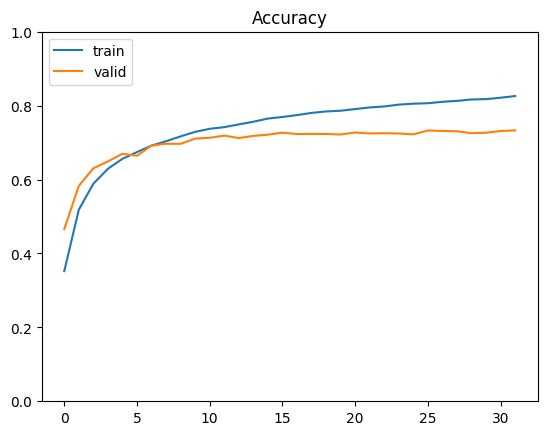

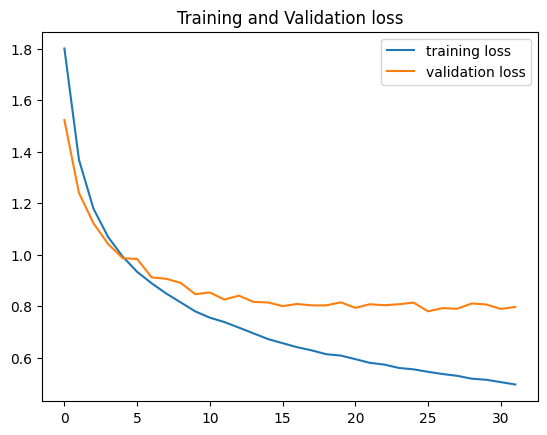

In [ ]:
#https://qiita.com/yy1003/items/c590d1a26918e4abe512やhttps://deepage.net/deep_learning/2016/10/26/batch_normalization.html参照

NUMBER_OF_EPOCH = 32
BATCH_SIZE = 128

input_size  = (img_rows,img_cols,1)

model_gray = create_2Dmodel(input_size)

model_gray.fit(X_train_gray[split_index[0][0]], y_train[split_index[0][0]],
              batch_size=BATCH_SIZE,
              epochs=NUMBER_OF_EPOCH,
              verbose=1,
              validation_data=(X_train_gray[split_index[0][1]], y_train[split_index[0][1]]),
              callbacks=[cp_callback])

plot_history_of_model(model_gray)

In [ ]:
"""
#保存済みの重みを読み込み
input_size  = (img_rows,img_cols,1)
model_gray = create_2Dmodel(input_size)

model_gray.load_weights(checkpoint_path)
"""

In [ ]:
del X_train_gray,y_train
gc.collect()

490

In [ ]:
pred_gray = model_gray.predict(X_test_gray)

count = 0
for i in range(len(X_test_gray)):
    if np.argmax(pred_gray[i]) == np.argmax(y_test[i]):
        count +=1

print("accuracy :",count/len(X_test_gray))

313/313 [==============================] - 1s 3ms/step
accuracy : 0.788


# アンサンブル学習

これまでの予測結果をアンサンブルすることで精度の向上を目指す。

In [ ]:
import seaborn as sns

pred_average = (pred_color + pred_color_masked + pred_gray + pred_masked_gray) / 4
count = 0

negative_list = np.zeros(10)
pred_list = np.zeros(10)

true = np.zeros(10)
pred = np.zeros(10)

my_matrix = np.zeros((10,10))

for i in range(len(pred_color)):
    if np.argmax(pred_average[i]) == np.argmax(y_test[i]):
        count +=1
    else:
      negative_list[np.argmax(y_test[i])] += 1
      pred_list[np.argmax(pred_average[i])] += 1

    true[np.argmax(y_test[i])] += 1
    pred[np.argmax(pred_average[i])] += 1

    my_matrix[np.argmax(y_test[i])][np.argmax(pred_average[i])] += 1

print("accuracy :",count/len(pred_color))
print(label_dict)
print(negative_list)
print(pred_list,"\n")

print(true)
print(pred,"\n")

print(my_matrix)

accuracy : 0.8421
{0: '飛行機', 1: '自動車', 2: '鳥', 3: '猫', 4: '鹿', 5: '犬', 6: 'カエル', 7: '馬', 8: '船', 9: 'トラック'}
[142.  74. 271. 302. 133. 273.  95. 124.  86.  79.]
[105.  72. 127. 312. 251. 160. 184. 122.  82. 164.] 

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
[ 963.  998.  856. 1010. 1118.  887. 1089.  998.  996. 1085.] 

[[858.  11.  17.  13.  17.   1.   9.   7.  39.  28.]
 [  1. 926.   0.   3.   2.   2.   1.   1.   7.  57.]
 [ 32.   3. 729.  40.  85.  37.  44.  20.   5.   5.]
 [ 10.   7.  30. 698.  59.  84.  55.  26.   7.  24.]
 [  4.   1.  26.  24. 867.   8.  33.  33.   4.   0.]
 [  5.   0.  19. 143.  44. 727.  25.  26.   2.   9.]
 [  8.   2.  20.  30.  15.   8. 905.   5.   5.   2.]
 [  4.   2.   8.  46.  25.  19.   5. 876.   2.  13.]
 [ 28.  14.   6.   5.   2.   0.   5.   0. 914.  26.]
 [ 13.  32.   1.   8.   2.   1.   7.   4.  11. 921.]]


上記のコードで出力した混同行列を視覚的に理解しやすく成形する。

In [ ]:
labels = ['飛行機', '自動車', '鳥', '猫', '鹿', '犬', 'カエル', '馬', '船', 'トラック']

In [ ]:
df = pd.DataFrame(data=my_matrix, index=labels, columns=labels)

In [ ]:
df

,飛行機,自動車,鳥,猫,鹿,犬,カエル,馬,船,トラック
飛行機,859.0,12.0,17.0,9.0,17.0,1.0,9.0,9.0,39.0,28.0
自動車,1.0,926.0,0.0,1.0,2.0,3.0,2.0,1.0,7.0,57.0
鳥,32.0,3.0,735.0,27.0,87.0,41.0,45.0,20.0,5.0,5.0
猫,13.0,8.0,35.0,637.0,66.0,114.0,61.0,29.0,7.0,30.0
鹿,4.0,1.0,26.0,18.0,871.0,9.0,33.0,33.0,4.0,1.0
犬,5.0,1.0,23.0,95.0,48.0,759.0,29.0,29.0,2.0,9.0
カエル,8.0,2.0,21.0,20.0,17.0,9.0,911.0,5.0,5.0,2.0
馬,4.0,2.0,9.0,28.0,27.0,22.0,6.0,886.0,2.0,14.0
船,29.0,14.0,6.0,4.0,2.0,0.0,5.0,0.0,914.0,26.0
トラック,13.0,32.0,1.0,6.0,2.0,1.0,7.0,4.0,11.0,923.0


In [ ]:
!pip install japanize_matplotlib

In [ ]:
import japanize_matplotlib

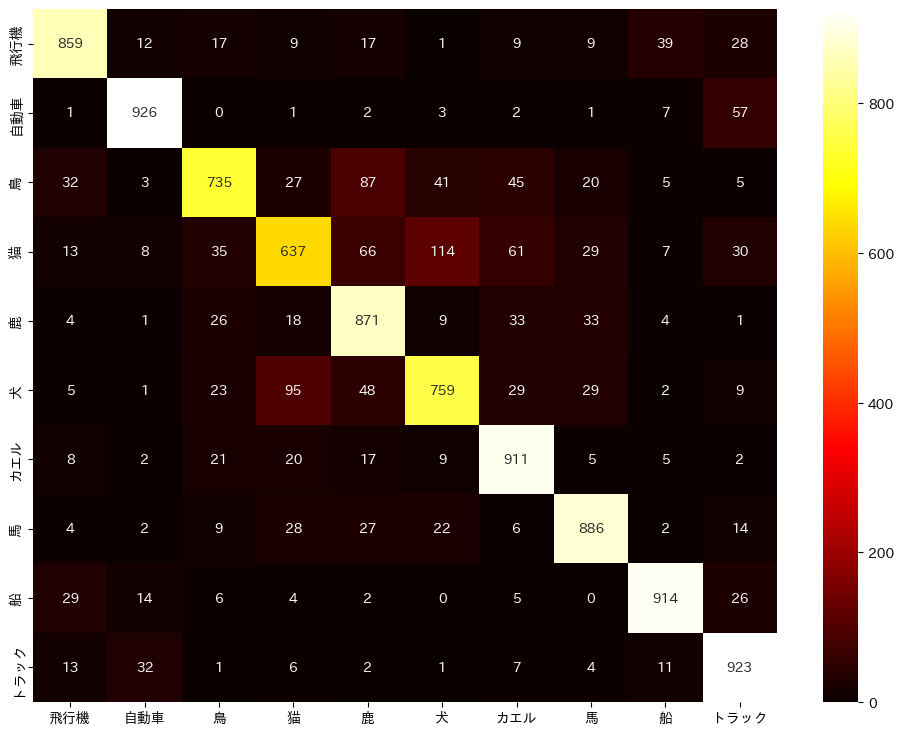

In [ ]:
plt.figure(figsize = (12,9))
plt.xlabel("pred")
plt.ylabel("true")
sns.heatmap(df, annot=True, cmap="hot",fmt='.0f')

plt.show()